In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.datasets
import torch
import numpy as np

In [2]:
original_data=pd.read_excel('covid.xlsx')
df=pd.DataFrame(original_data)

In [3]:
original=df.iloc[348:621,[0,1]]
original

일자  계(명)
348  2021-01-01 00:00:00  1027
349  2021-01-02 00:00:00   820
350  2021-01-03 00:00:00   657
351  2021-01-04 00:00:00  1020
352  2021-01-05 00:00:00   714
..                   ...   ...
616  2021-09-26 00:00:00  2768
617  2021-09-27 00:00:00  2381
618  2021-09-28 00:00:00  2288
619  2021-09-29 00:00:00  2881
620  2021-09-30 00:00:00  2561

[273 rows x 2 columns]

In [4]:
original=original.T
original.loc['공휴일']=0
original


348                  349                  350  \
일자    2021-01-01 00:00:00  2021-01-02 00:00:00  2021-01-03 00:00:00   
계(명)                 1027                  820                  657   
공휴일                     0                    0                    0   

                      351                  352                  353  \
일자    2021-01-04 00:00:00  2021-01-05 00:00:00  2021-01-06 00:00:00   
계(명)                 1020                  714                  838   
공휴일                     0                    0                    0   

                      354                  355                  356  \
일자    2021-01-07 00:00:00  2021-01-08 00:00:00  2021-01-09 00:00:00   
계(명)                  869                  674                  641   
공휴일                     0                    0                    0   

                      357  ...                  611                  612  \
일자    2021-01-10 00:00:00  ...  2021-09-21 00:00:00  2021-09-22 00:00:00   
계(명)                  657  ...                 1729                 1720   
공휴일                     0  ...                    0                    0   

                      613                  614                  615  \
일자    2021-09-23 00:00:00  2021-09-24 00:00:00  2021-09-25 00:00:00   
계(명)                 1715                 2429                 3270   
공휴일                     0                    0                    0   

                      616                  617                  618  \
일자    2021-09-26 00:00:00  2021-09-27 00:00:00  2021-09-28 00:00:00   
계(명)                 2768                 2381                 2288   
공휴일                     0                    0                    0   

                      619                  620  
일자    2021-09-29 00:00:00  2021-09-30 00:00:00  
계(명)                 2881                 2561  
공휴일                     0                    0  

[3 rows x 273 columns]

In [5]:

from datetime import date
from datetime import datetime
import time
b=((1,1),(2,11),(2,12),(2,13),(3,1),(5,5),(5,19),(6,6),(8,15),(8,16),(9,20),(9,21),(10,3),(10,4),(10,9),(10,11))
holiday=[]
for m,d in b:
    holiday.append(date(2021,m,d))
def is_weekend(d):
    d=date(2021,d.month,d.day)
    a=d.weekday() > 4
    b=d in holiday
    if a or b == True:
        return float(1)
    else:
        return float(0)
idx=0

In [6]:
for i in original.iloc[0,:]:
    original.iloc[2,idx]=is_weekend(i)
    idx+=1
original

348                  349                  350  \
일자    2021-01-01 00:00:00  2021-01-02 00:00:00  2021-01-03 00:00:00   
계(명)                 1027                  820                  657   
공휴일                   1.0                  1.0                  1.0   

                      351                  352                  353  \
일자    2021-01-04 00:00:00  2021-01-05 00:00:00  2021-01-06 00:00:00   
계(명)                 1020                  714                  838   
공휴일                   0.0                  0.0                  0.0   

                      354                  355                  356  \
일자    2021-01-07 00:00:00  2021-01-08 00:00:00  2021-01-09 00:00:00   
계(명)                  869                  674                  641   
공휴일                   0.0                  0.0                  1.0   

                      357  ...                  611                  612  \
일자    2021-01-10 00:00:00  ...  2021-09-21 00:00:00  2021-09-22 00:00:00   
계(명)                  657  ...                 1729                 1720   
공휴일                   1.0  ...                  1.0                  0.0   

                      613                  614                  615  \
일자    2021-09-23 00:00:00  2021-09-24 00:00:00  2021-09-25 00:00:00   
계(명)                 1715                 2429                 3270   
공휴일                   0.0                  0.0                  1.0   

                      616                  617                  618  \
일자    2021-09-26 00:00:00  2021-09-27 00:00:00  2021-09-28 00:00:00   
계(명)                 2768                 2381                 2288   
공휴일                   1.0                  0.0                  0.0   

                      619                  620  
일자    2021-09-29 00:00:00  2021-09-30 00:00:00  
계(명)                 2881                 2561  
공휴일                   0.0                  0.0  

[3 rows x 273 columns]

In [7]:
data_set = pd.DataFrame(index=range(0,273-4), columns=['당일', '1일전', '2일전', '3일전', '4일전', '당일 공휴일','1일전 공휴일','2일전 공휴일','3일전 공휴일','4일전 공휴일'])
data_set#5일치를 해야 함으로 데이터 앞의 4일은 삭제

당일  1일전  2일전  3일전  4일전 당일 공휴일 1일전 공휴일 2일전 공휴일 3일전 공휴일 4일전 공휴일
0    NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
1    NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
2    NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
3    NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
4    NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
..   ...  ...  ...  ...  ...    ...     ...     ...     ...     ...
264  NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
265  NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
266  NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
267  NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN
268  NaN  NaN  NaN  NaN  NaN    NaN     NaN     NaN     NaN     NaN

[269 rows x 10 columns]

In [8]:
for i in range(269):
    data_set.iloc[i,0:5]=original.iloc[1,i:i+5]
    data_set.iloc[i,5:]=original.iloc[2,i:i+5]
data_set

당일   1일전   2일전   3일전   4일전 당일 공휴일 1일전 공휴일 2일전 공휴일 3일전 공휴일 4일전 공휴일
0    1027   820   657  1020   714    1.0     1.0     1.0     0.0     0.0
1     820   657  1020   714   838    1.0     1.0     0.0     0.0     0.0
2     657  1020   714   838   869    1.0     0.0     0.0     0.0     0.0
3    1020   714   838   869   674    0.0     0.0     0.0     0.0     0.0
4     714   838   869   674   641    0.0     0.0     0.0     0.0     1.0
..    ...   ...   ...   ...   ...    ...     ...     ...     ...     ...
264  1720  1715  2429  3270  2768    0.0     0.0     0.0     1.0     1.0
265  1715  2429  3270  2768  2381    0.0     0.0     1.0     1.0     0.0
266  2429  3270  2768  2381  2288    0.0     1.0     1.0     0.0     0.0
267  3270  2768  2381  2288  2881    1.0     1.0     0.0     0.0     0.0
268  2768  2381  2288  2881  2561    1.0     0.0     0.0     0.0     0.0

[269 rows x 10 columns]

In [9]:
ma=data_set.iloc[:,0].max()
mi=data_set.iloc[:,0].min()
for i in range(269):
    x=data_set.iloc[i,0:5]
    for j in range(5):
        x0=x.iloc[j]
        x.iloc[j]=(x0-mi)/(ma-mi)
data_set

당일       1일전       2일전       3일전       4일전 당일 공휴일 1일전 공휴일 2일전 공휴일  \
0     0.24782  0.178404  0.123742  0.245473  0.142857    1.0     1.0     1.0   
1    0.178404  0.123742  0.245473  0.142857   0.18444    1.0     1.0     0.0   
2    0.123742  0.245473  0.142857   0.18444  0.194836    1.0     0.0     0.0   
3    0.245473  0.142857   0.18444  0.194836  0.129443    0.0     0.0     0.0   
4    0.142857   0.18444  0.194836  0.129443  0.118377    0.0     0.0     0.0   
..        ...       ...       ...       ...       ...    ...     ...     ...   
264  0.480215  0.478538  0.717975       1.0  0.831657    0.0     0.0     0.0   
265  0.478538  0.717975       1.0  0.831657  0.701878    0.0     0.0     1.0   
266  0.717975       1.0  0.831657  0.701878  0.670691    0.0     1.0     1.0   
267       1.0  0.831657  0.701878  0.670691  0.869551    1.0     1.0     0.0   
268  0.831657  0.701878  0.670691  0.869551   0.76224    1.0     0.0     0.0   

    3일전 공휴일 4일전 공휴일  
0       0.0     0.0  
1       0.0     0.0  
2       0.0     0.0  
3       0.0     0.0  
4       0.0     1.0  
..      ...     ...  
264     1.0     1.0  
265     1.0     0.0  
266     0.0     0.0  
267     0.0     0.0  
268     0.0     0.0  

[269 rows x 10 columns]

In [10]:
#트레이닝 셋 : 테스트 셋 = 7:3

In [11]:
train_x=data_set.iloc[0:189,[1,2,3,4,6,7,8,9]]
test_x=data_set.iloc[190:268,[1,2,3,4,6,7,8,9]]
train_y=data_set.iloc[0:189,[0]]
test_y=data_set.iloc[190:268,[0]]

In [12]:
train_x

1일전       2일전       3일전       4일전 1일전 공휴일 2일전 공휴일 3일전 공휴일 4일전 공휴일
0    0.178404  0.123742  0.245473  0.142857     1.0     1.0     0.0     0.0
1    0.123742  0.245473  0.142857   0.18444     1.0     0.0     0.0     0.0
2    0.245473  0.142857   0.18444  0.194836     0.0     0.0     0.0     0.0
3    0.142857   0.18444  0.194836  0.129443     0.0     0.0     0.0     0.0
4     0.18444  0.194836  0.129443  0.118377     0.0     0.0     0.0     1.0
..        ...       ...       ...       ...     ...     ...     ...     ...
184  0.141851  0.153588  0.309524  0.330986     0.0     0.0     0.0     0.0
185  0.153588  0.309524  0.330986  0.344735     0.0     0.0     0.0     0.0
186  0.309524  0.330986  0.344735  0.365526     0.0     0.0     0.0     1.0
187  0.330986  0.344735  0.365526  0.347418     0.0     0.0     1.0     1.0
188  0.344735  0.365526  0.347418    0.2723     0.0     1.0     1.0     0.0

[189 rows x 8 columns]

In [13]:
train_y

당일
0     0.24782
1    0.178404
2    0.123742
3    0.245473
4    0.142857
..        ...
184  0.152582
185  0.141851
186  0.153588
187  0.309524
188  0.330986

[189 rows x 1 columns]

In [14]:
train_x, train_y=torch.Tensor(list(train_x.values)),torch.Tensor(list(train_y.values))
test_x,test_y=torch.Tensor(list(test_x.values)),torch.Tensor(list(test_y.values))

<ipython-input-14-fba70a3db33f>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_x, train_y=torch.Tensor(list(train_x.values)),torch.Tensor(list(train_y.values))


In [15]:
ds_train = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=50, shuffle=True)

In [16]:
ds_test = torch.utils.data.TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=50, shuffle=True)

In [17]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self,):
        super().__init__()
        input_dim=8
        output_dim=1
        self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 150)
        self.blinear2 = BayesianLinear(150, output_dim)
        
    def forward(self, x):
        x1 = self.blinear1(x)
        x2 = self.blinear2(x1)
        return x2


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor().to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

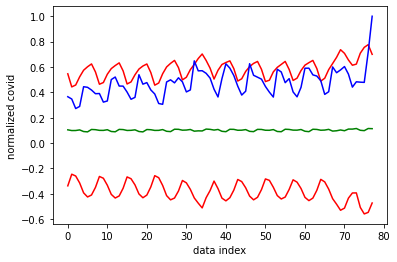

정확도: 0.95
Loss: 0.1595


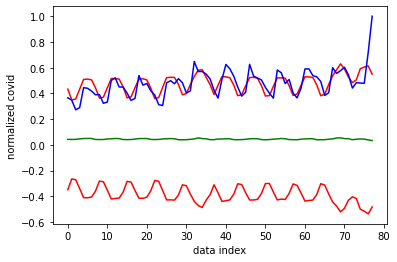

정확도: 0.54
Loss: 0.2055


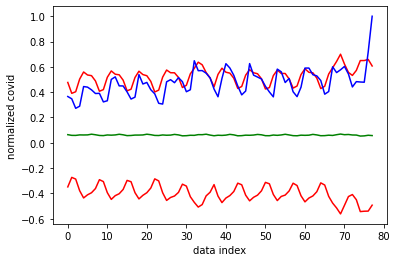

정확도: 0.77
Loss: 0.2325


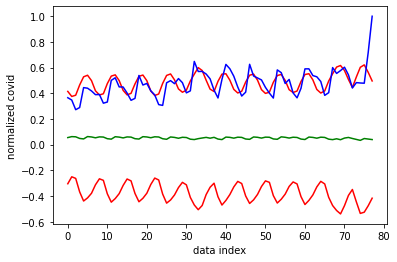

정확도: 0.58
Loss: 0.2162


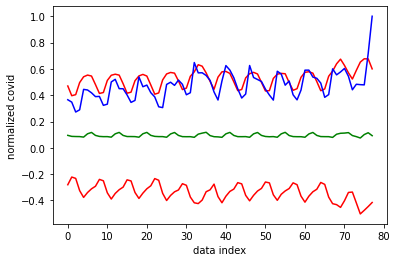

정확도: 0.74
Loss: 0.2441


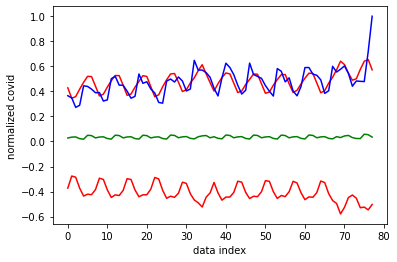

정확도: 0.58
Loss: 0.2307


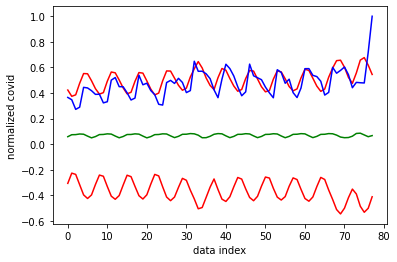

정확도: 0.64
Loss: 0.1972


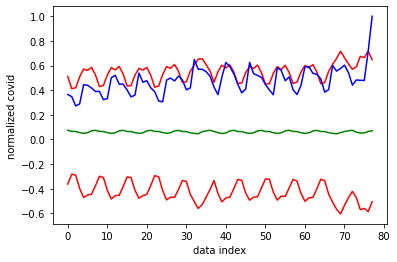

정확도: 0.90
Loss: 0.2617


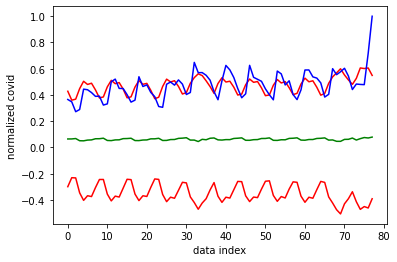

정확도: 0.51
Loss: 0.2225


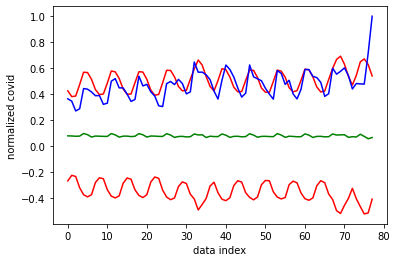

정확도: 0.71
Loss: 0.1994


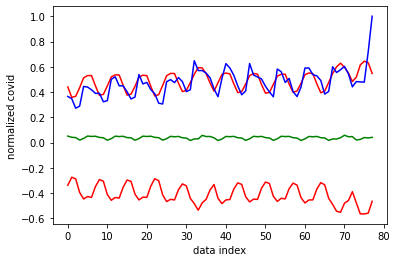

정확도: 0.62
Loss: 0.2054


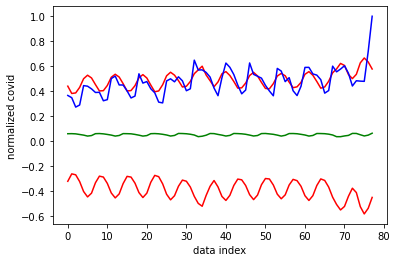

정확도: 0.67
Loss: 0.1746


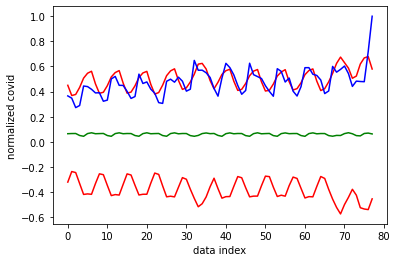

정확도: 0.67
Loss: 0.1630


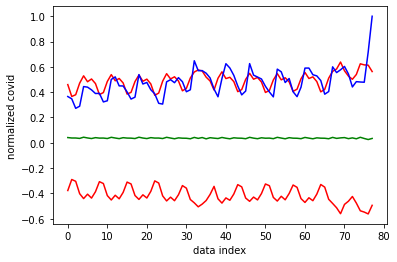

정확도: 0.56
Loss: 0.1414


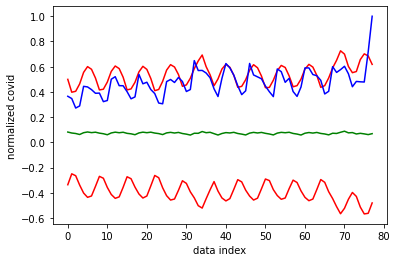

정확도: 0.83
Loss: 0.2688


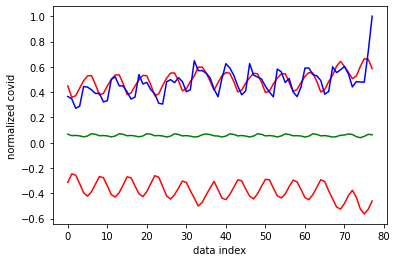

정확도: 0.65
Loss: 0.2461


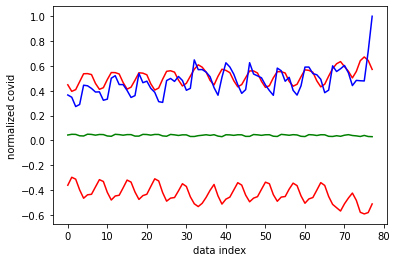

정확도: 0.71
Loss: 0.2273


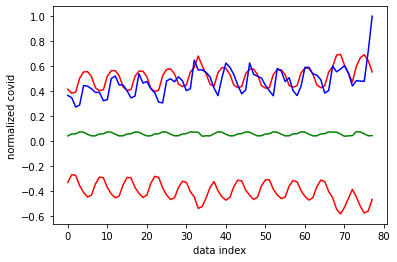

정확도: 0.69
Loss: 0.1674


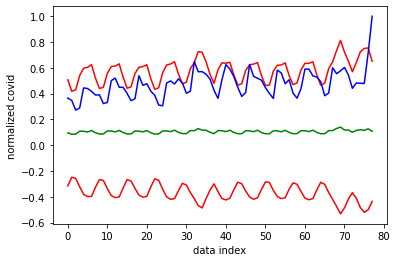

정확도: 0.94
Loss: 0.2085


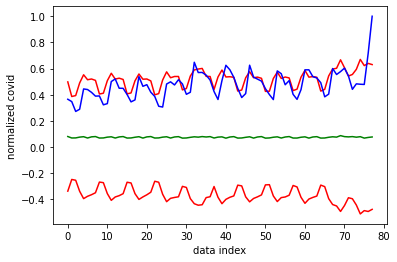

정확도: 0.76
Loss: 0.2274


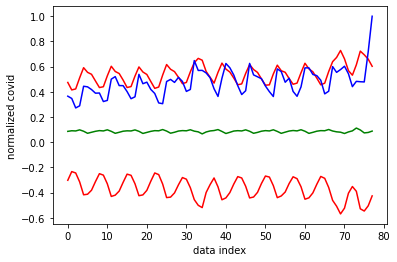

정확도: 0.83
Loss: 0.1867


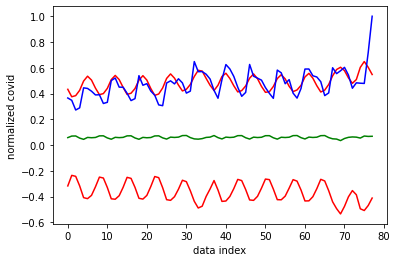

정확도: 0.60
Loss: 0.1341


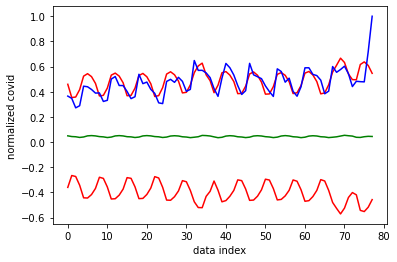

정확도: 0.59
Loss: 0.2153


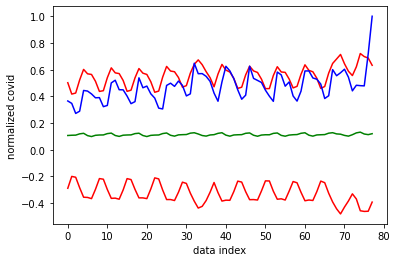

정확도: 0.90
Loss: 0.2244


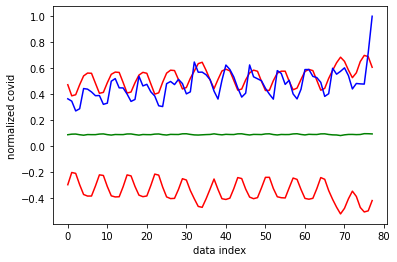

정확도: 0.76
Loss: 0.2141


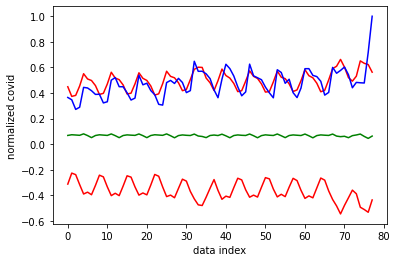

정확도: 0.59
Loss: 0.2312


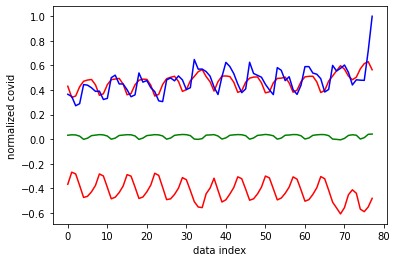

정확도: 0.47
Loss: 0.2843


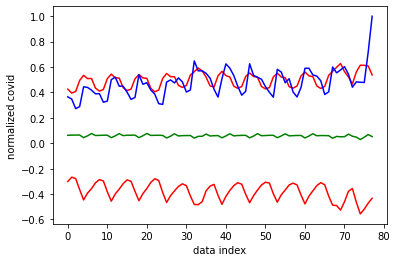

정확도: 0.63
Loss: 0.2182


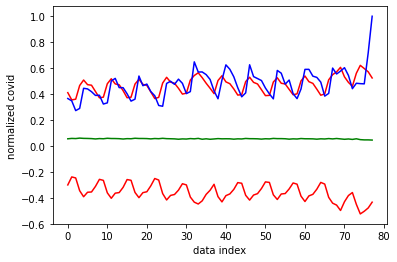

정확도: 0.47
Loss: 0.1994


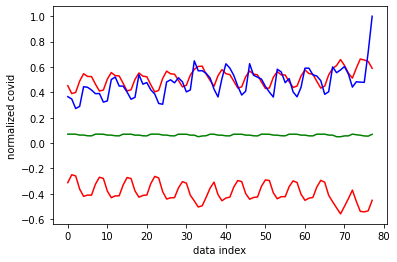

정확도: 0.72
Loss: 0.2167


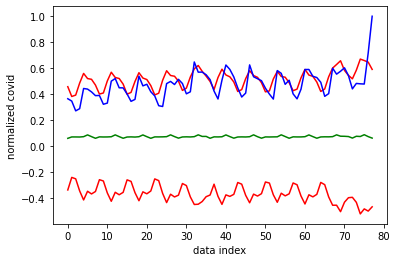

정확도: 0.71
Loss: 0.2423


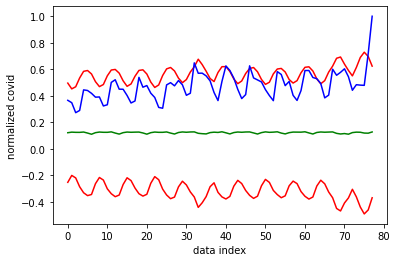

정확도: 0.88
Loss: 0.1686


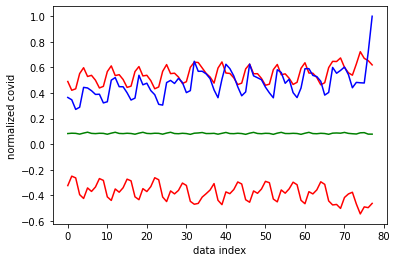

정확도: 0.85
Loss: 0.2973


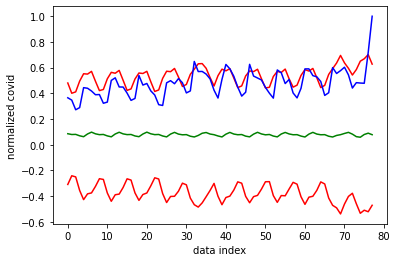

정확도: 0.81
Loss: 0.1872


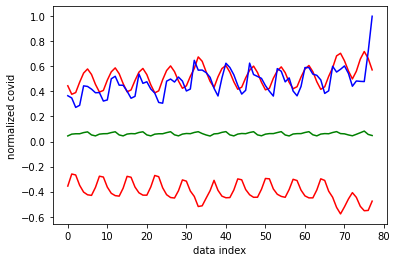

정확도: 0.74
Loss: 0.1562


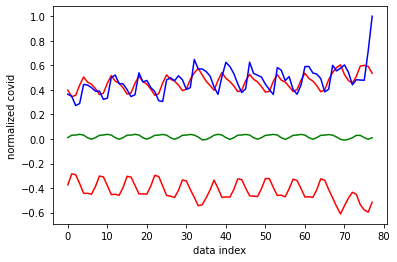

정확도: 0.45
Loss: 0.2034


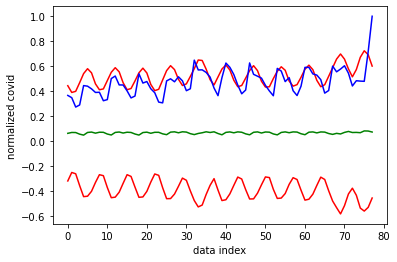

정확도: 0.76
Loss: 0.1867


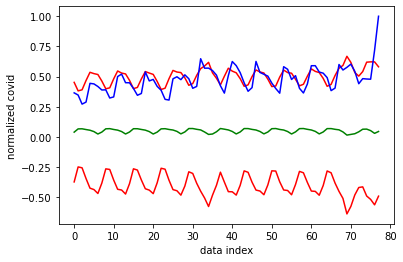

정확도: 0.68
Loss: 0.1059


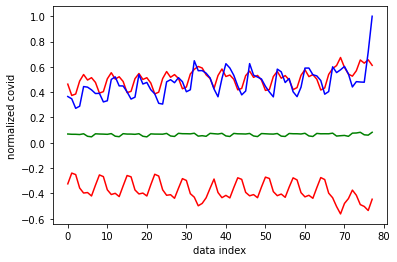

정확도: 0.64
Loss: 0.2231


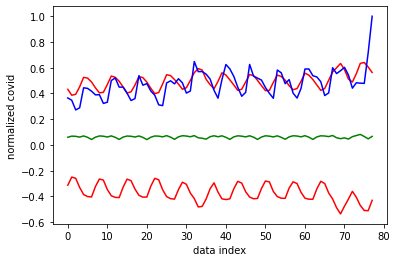

정확도: 0.65
Loss: 0.2681


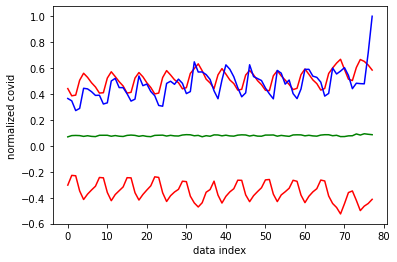

정확도: 0.69
Loss: 0.2122


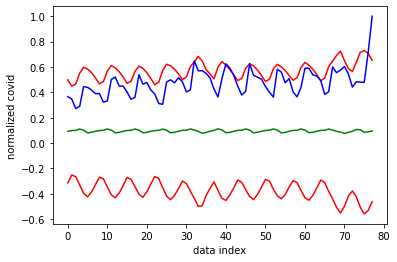

정확도: 0.91
Loss: 0.1998


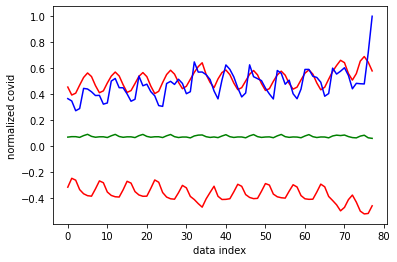

정확도: 0.73
Loss: 0.1832


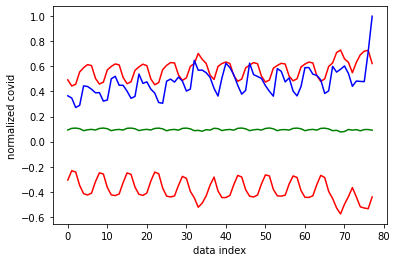

정확도: 0.92
Loss: 0.1825


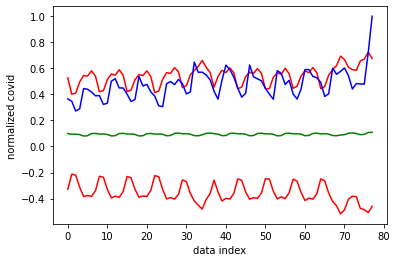

정확도: 0.83
Loss: 0.1532


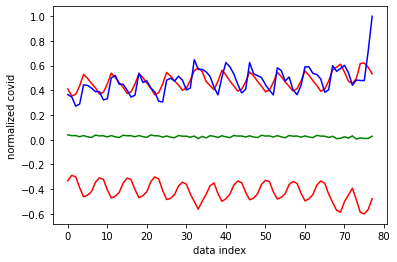

정확도: 0.49
Loss: 0.1730


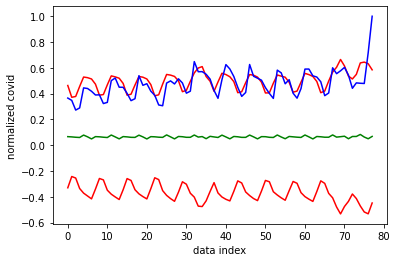

정확도: 0.63
Loss: 0.1739


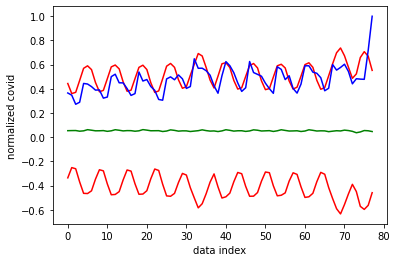

정확도: 0.73
Loss: 0.2346


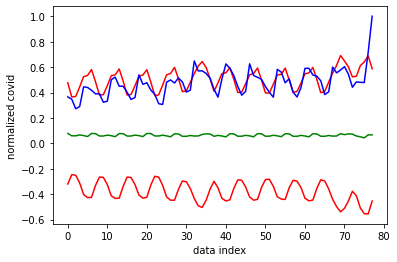

정확도: 0.65
Loss: 0.1928


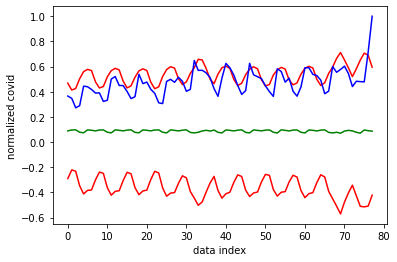

정확도: 0.77
Loss: 0.2130


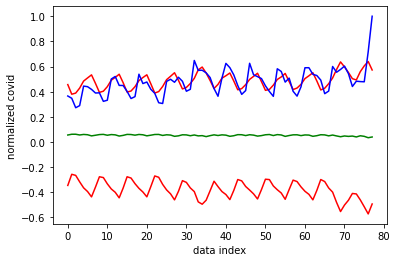

정확도: 0.63
Loss: 0.2299


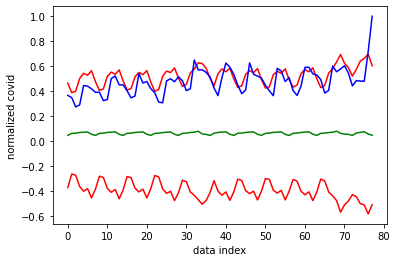

정확도: 0.73
Loss: 0.2178


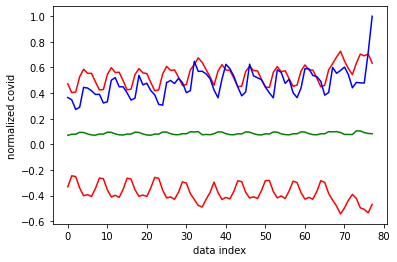

정확도: 0.86
Loss: 0.2159


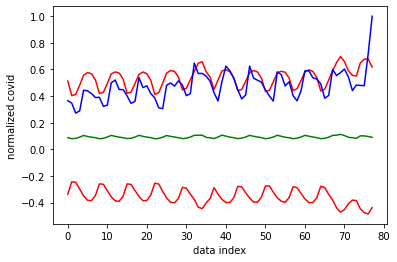

정확도: 0.83
Loss: 0.1996


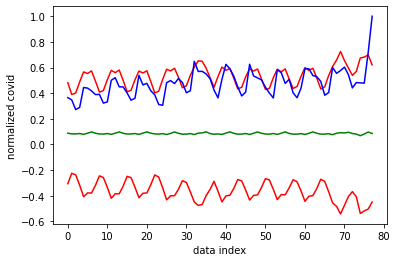

정확도: 0.85
Loss: 0.2363


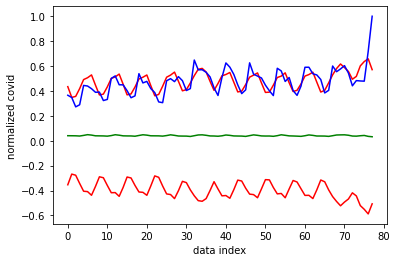

정확도: 0.59
Loss: 0.1855


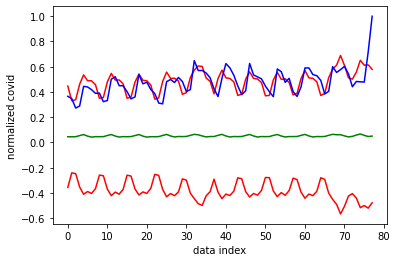

정확도: 0.55
Loss: 0.2425


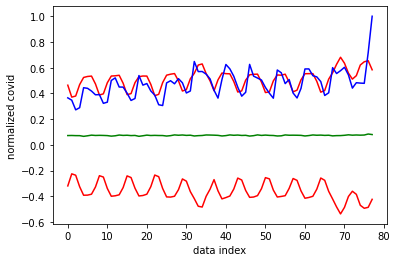

정확도: 0.67
Loss: 0.2802


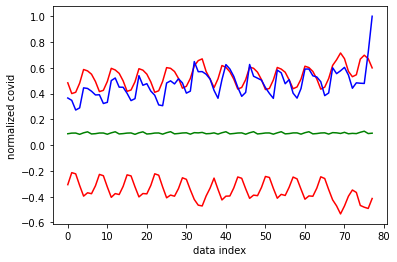

정확도: 0.83
Loss: 0.1946


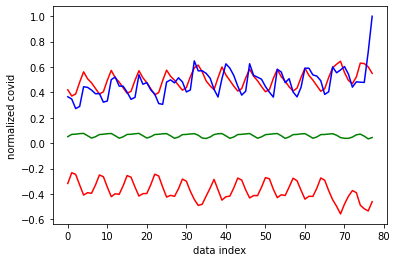

정확도: 0.56
Loss: 0.2093


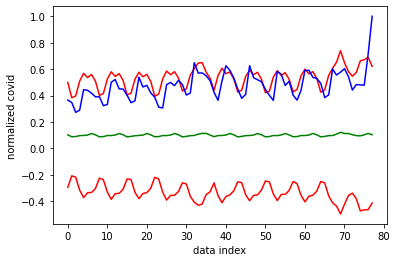

정확도: 0.82
Loss: 0.3055


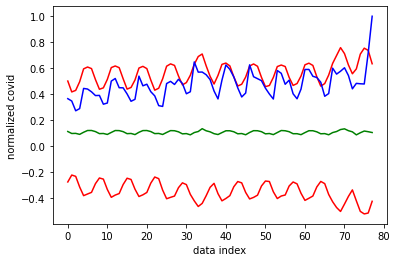

정확도: 0.94
Loss: 0.2108


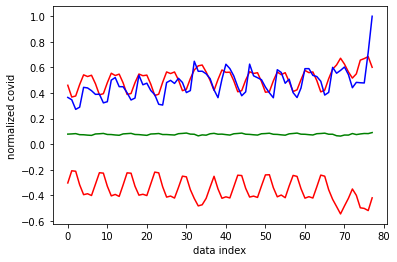

정확도: 0.68
Loss: 0.1883


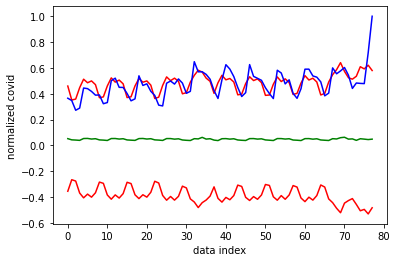

정확도: 0.54
Loss: 0.1745


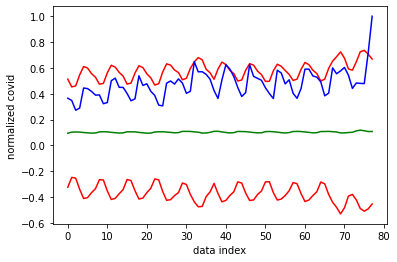

정확도: 0.95
Loss: 0.1793


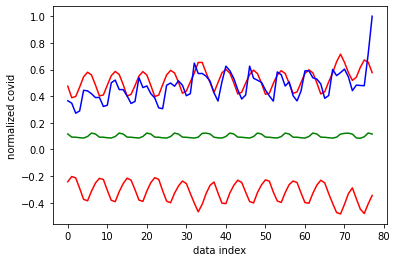

정확도: 0.74
Loss: 0.1427


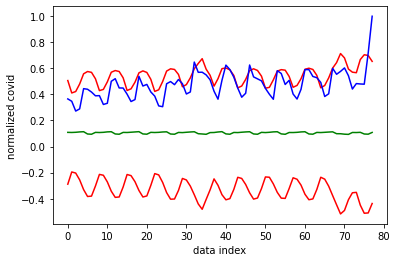

정확도: 0.88
Loss: 0.1899


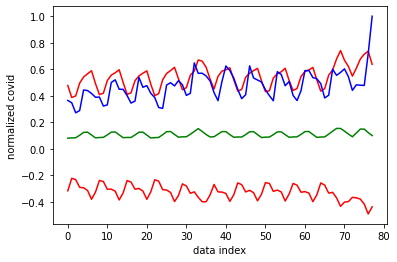

정확도: 0.83
Loss: 0.2404


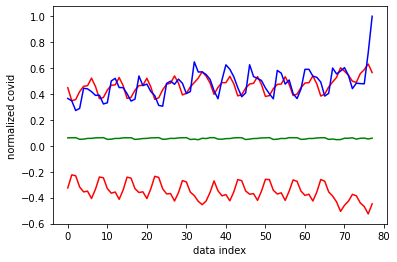

정확도: 0.51
Loss: 0.2102


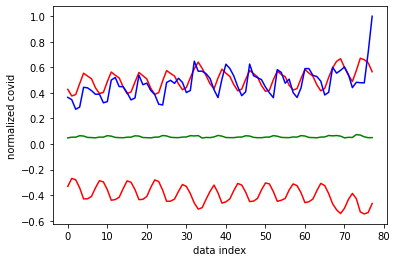

정확도: 0.65
Loss: 0.1820


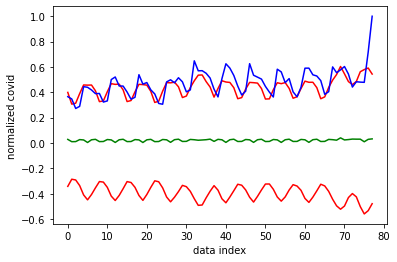

정확도: 0.33
Loss: 0.1754


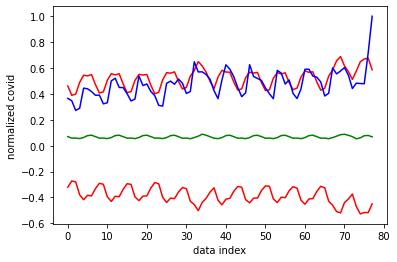

정확도: 0.73
Loss: 0.1991


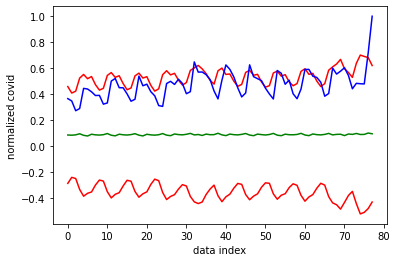

정확도: 0.77
Loss: 0.1846


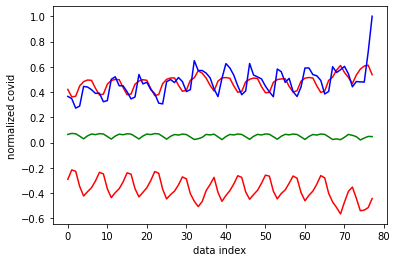

정확도: 0.50
Loss: 0.1869


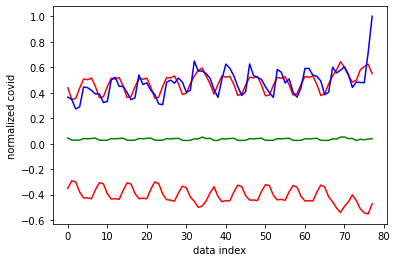

정확도: 0.55
Loss: 0.2151


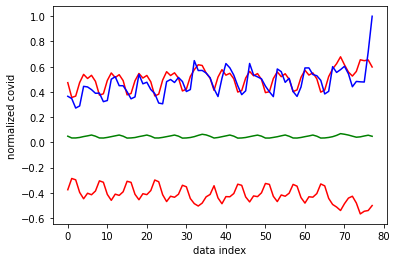

정확도: 0.64
Loss: 0.1382


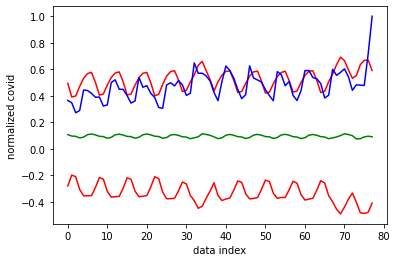

정확도: 0.78
Loss: 0.2423


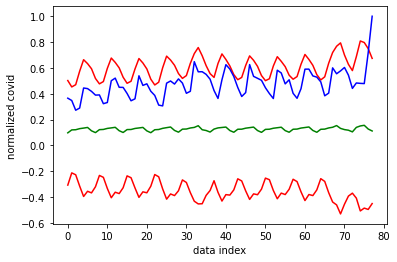

정확도: 0.99
Loss: 0.1733


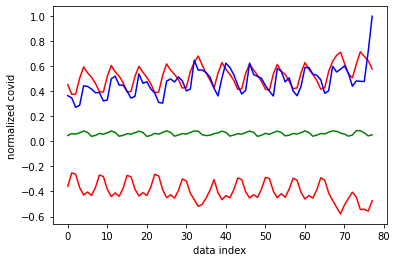

정확도: 0.72
Loss: 0.1872


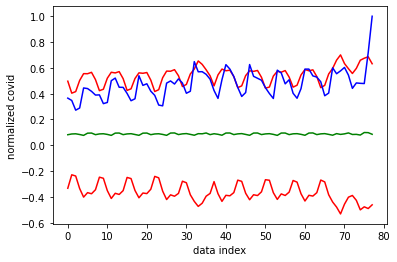

정확도: 0.81
Loss: 0.1956


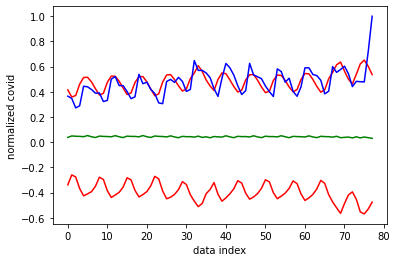

정확도: 0.56
Loss: 0.2423


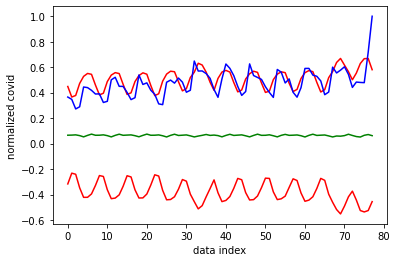

정확도: 0.68
Loss: 0.1611


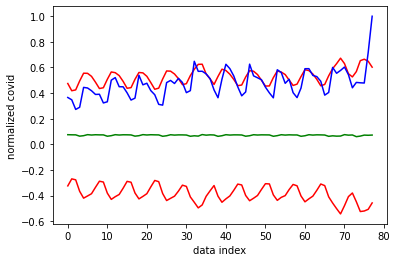

정확도: 0.76
Loss: 0.1685


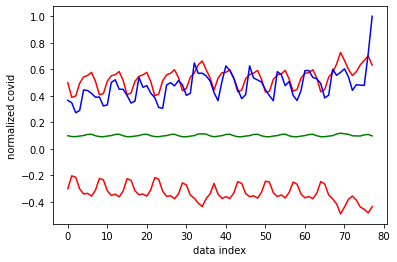

정확도: 0.82
Loss: 0.1829


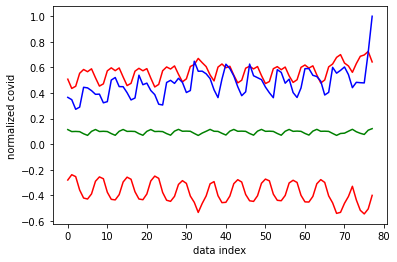

정확도: 0.94
Loss: 0.2362


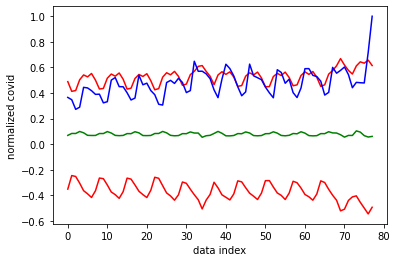

정확도: 0.81
Loss: 0.2791


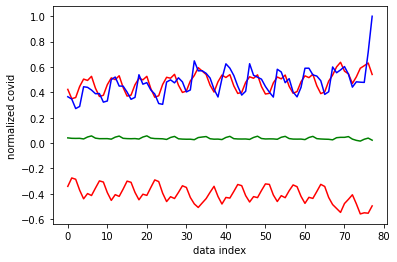

정확도: 0.56
Loss: 0.1595


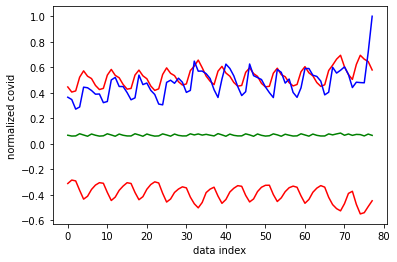

정확도: 0.76
Loss: 0.1991


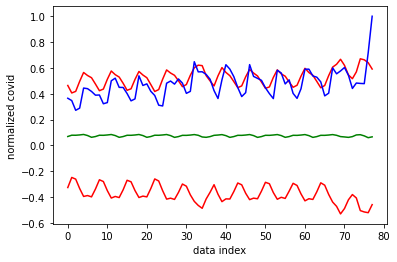

정확도: 0.76
Loss: 0.1984


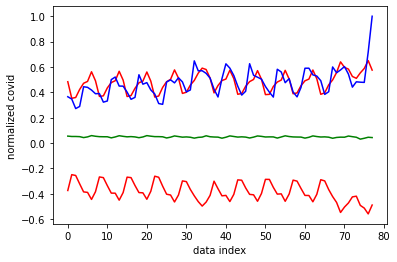

정확도: 0.55
Loss: 0.1778


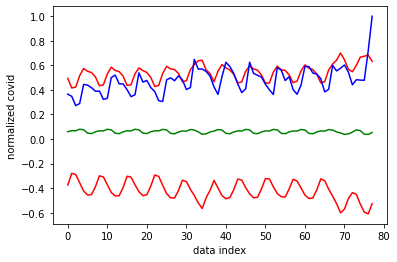

정확도: 0.87
Loss: 0.1870


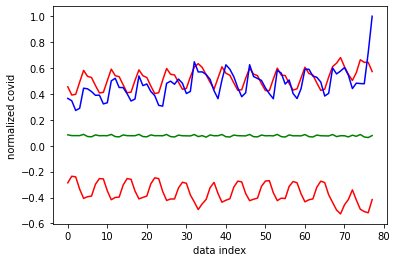

정확도: 0.76
Loss: 0.1730


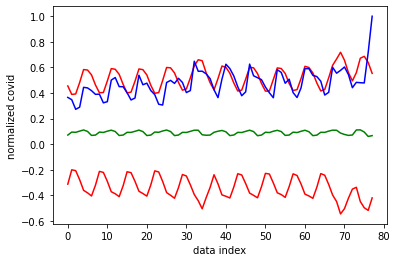

정확도: 0.78
Loss: 0.2583


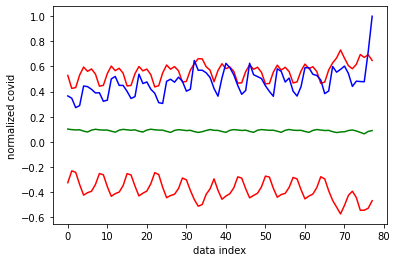

정확도: 0.90
Loss: 0.1954


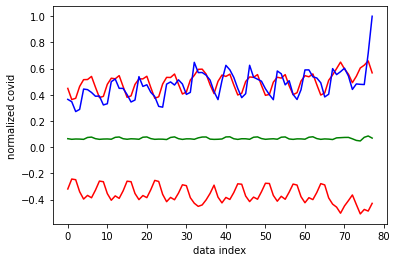

정확도: 0.63
Loss: 0.1887


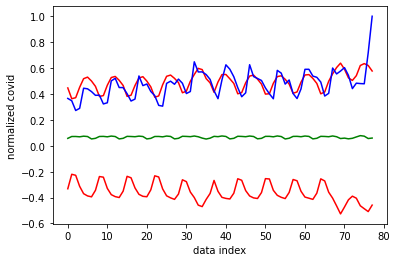

정확도: 0.60
Loss: 0.1933


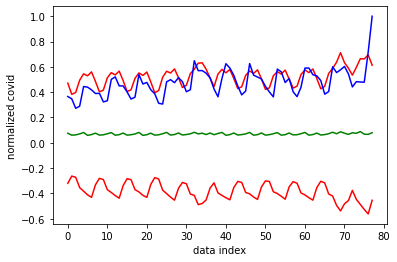

정확도: 0.74
Loss: 0.2558


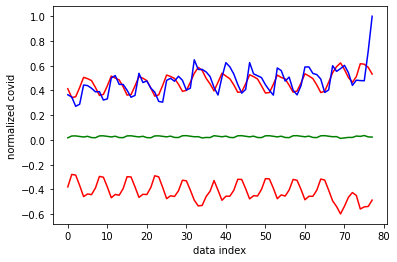

정확도: 0.50
Loss: 0.2388


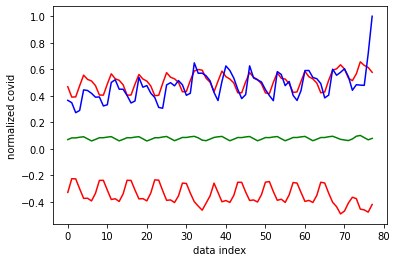

정확도: 0.68
Loss: 0.2447


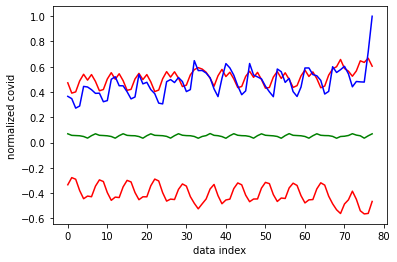

정확도: 0.69
Loss: 0.2333


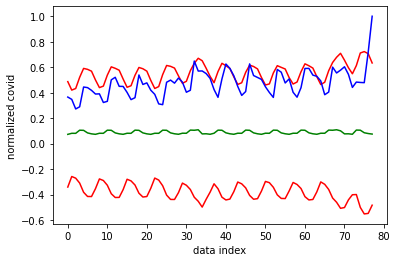

정확도: 0.87
Loss: 0.2352


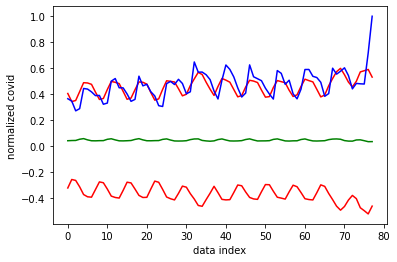

정확도: 0.46
Loss: 0.2361


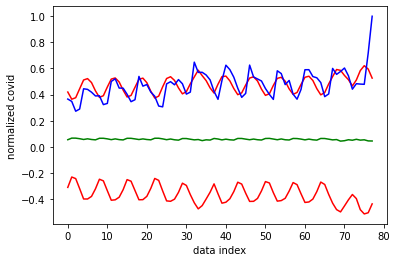

정확도: 0.56
Loss: 0.1836


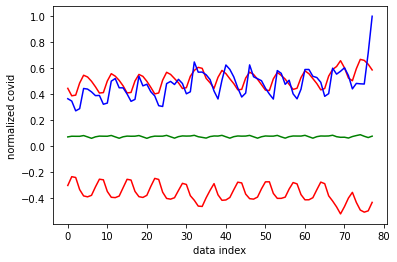

정확도: 0.67
Loss: 0.1873


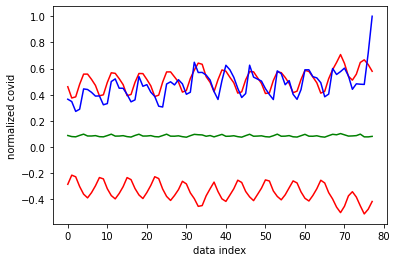

정확도: 0.67
Loss: 0.2054


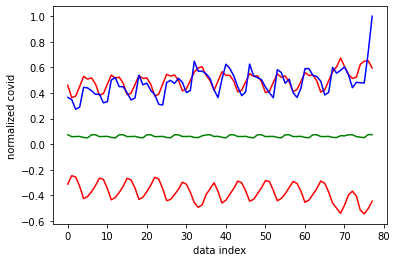

정확도: 0.63
Loss: 0.2304


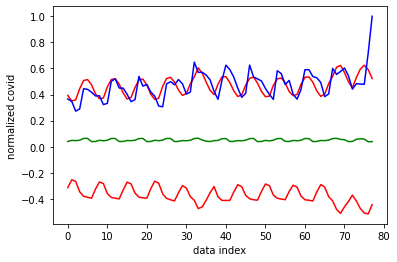

정확도: 0.51
Loss: 0.2412


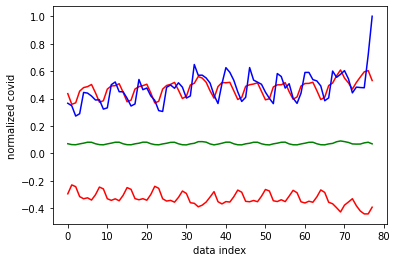

정확도: 0.50
Loss: 0.2188


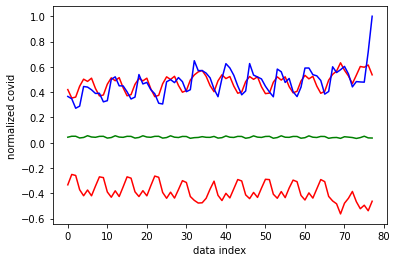

정확도: 0.54
Loss: 0.1643


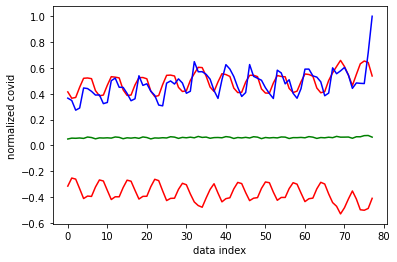

정확도: 0.63
Loss: 0.1775


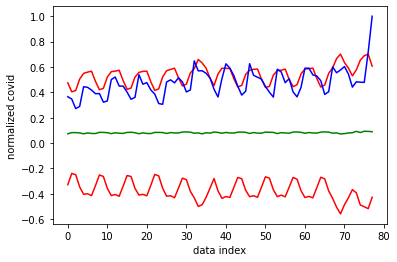

정확도: 0.74
Loss: 0.1954


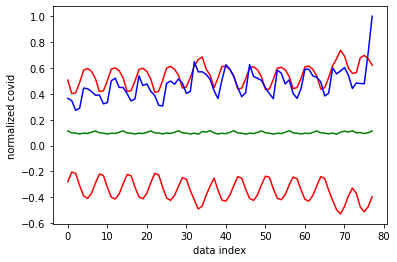

정확도: 0.87
Loss: 0.1744


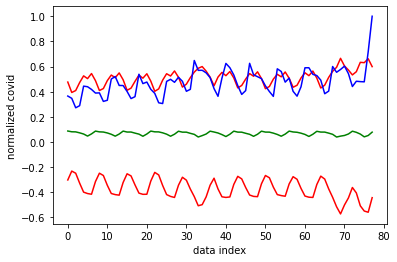

정확도: 0.73
Loss: 0.1963


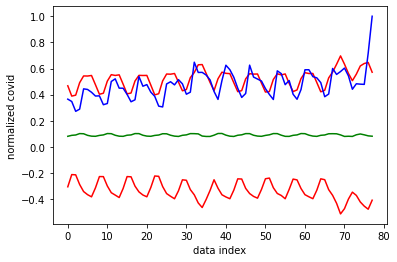

정확도: 0.73
Loss: 0.2260


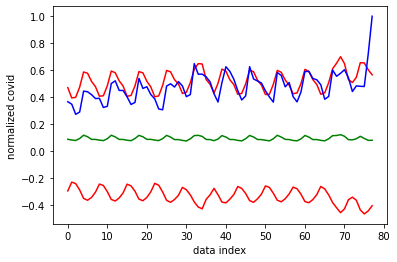

정확도: 0.74
Loss: 0.2118


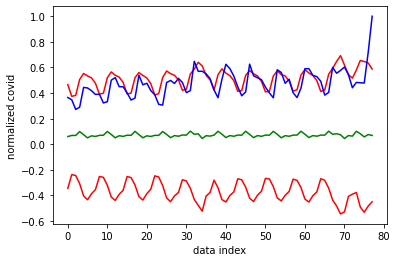

정확도: 0.67
Loss: 0.1469


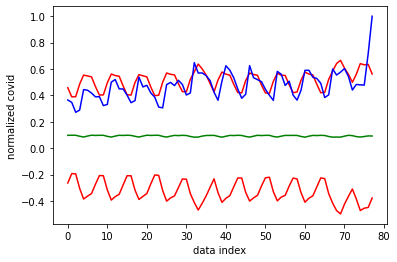

정확도: 0.73
Loss: 0.2418


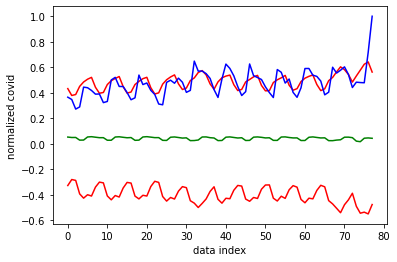

정확도: 0.63
Loss: 0.1747


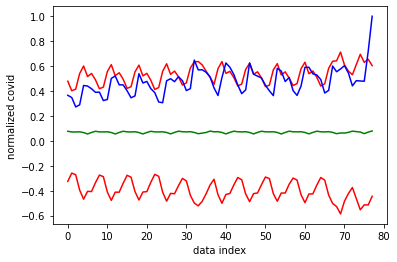

정확도: 0.79
Loss: 0.1944


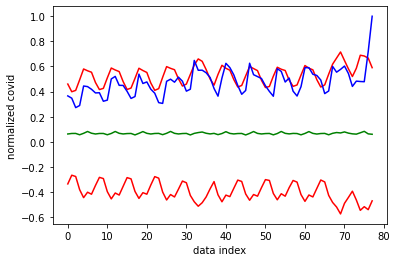

정확도: 0.78
Loss: 0.2345


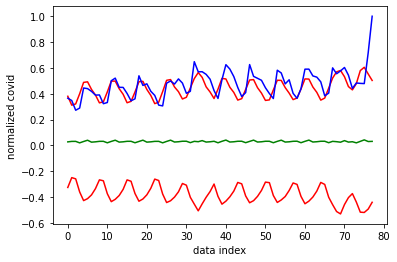

정확도: 0.33
Loss: 0.1864


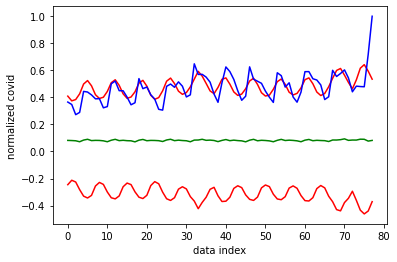

정확도: 0.59
Loss: 0.1646


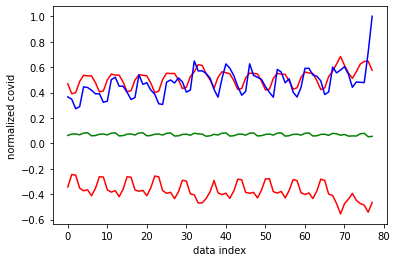

정확도: 0.72
Loss: 0.1769


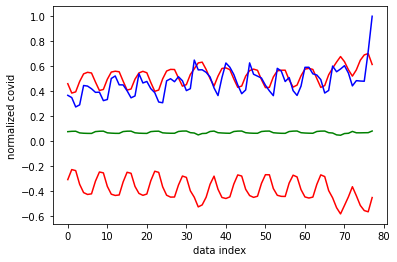

정확도: 0.74
Loss: 0.2331


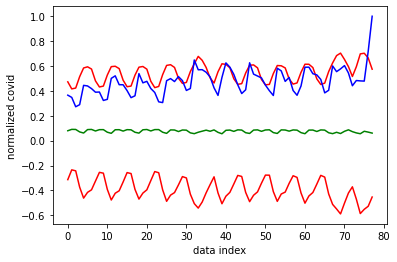

정확도: 0.82
Loss: 0.1831


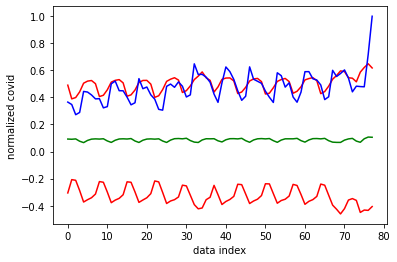

정확도: 0.73
Loss: 0.2214


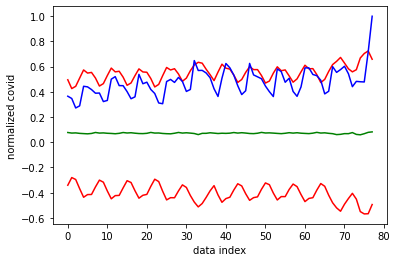

정확도: 0.91
Loss: 0.1866


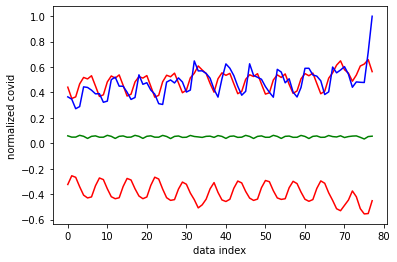

정확도: 0.59
Loss: 0.1714


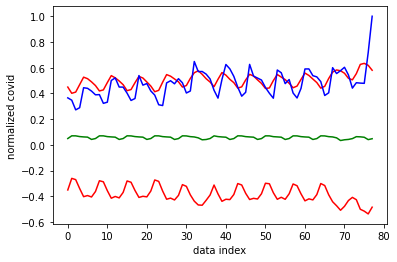

정확도: 0.63
Loss: 0.1955


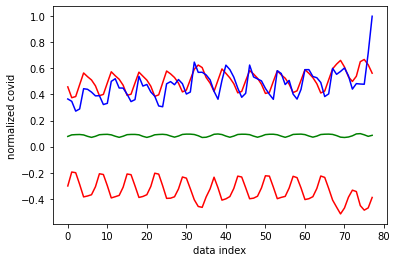

정확도: 0.67
Loss: 0.2045


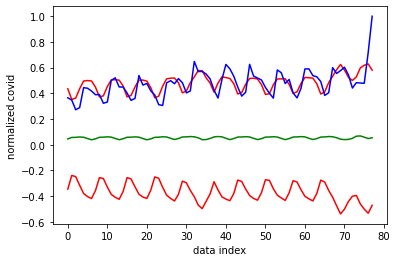

정확도: 0.55
Loss: 0.2086


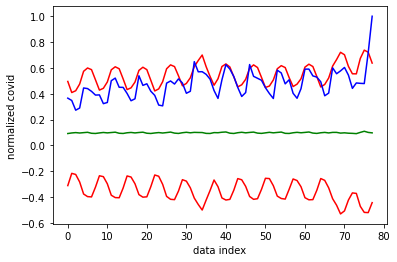

정확도: 0.92
Loss: 0.2322


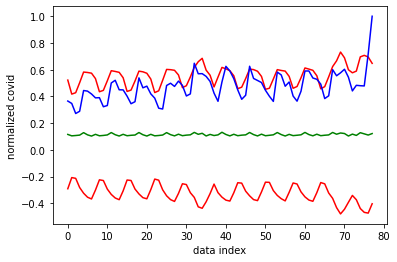

정확도: 0.91
Loss: 0.2073


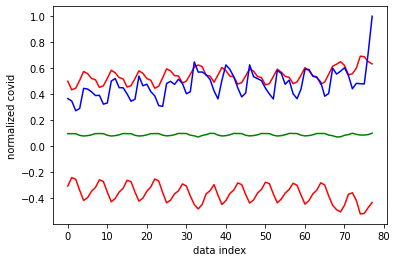

정확도: 0.88
Loss: 0.2491


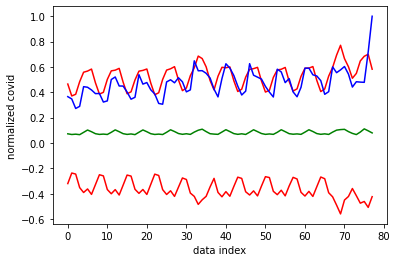

정확도: 0.71
Loss: 0.1716


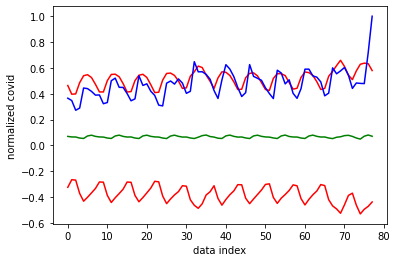

정확도: 0.72
Loss: 0.2228


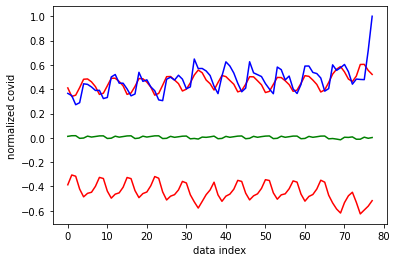

정확도: 0.44
Loss: 0.1945


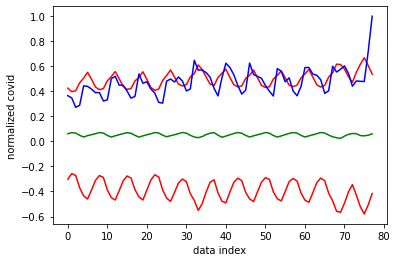

정확도: 0.65
Loss: 0.2089


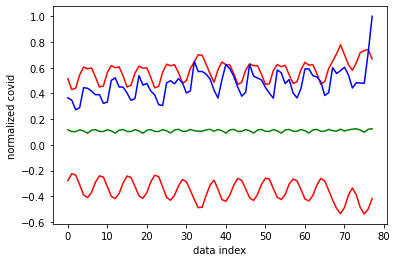

정확도: 0.94
Loss: 0.1811


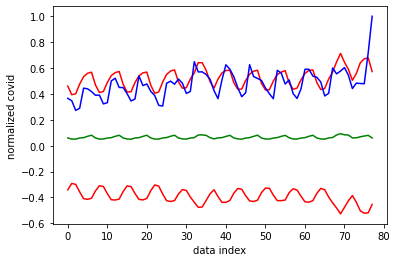

정확도: 0.73
Loss: 0.2229


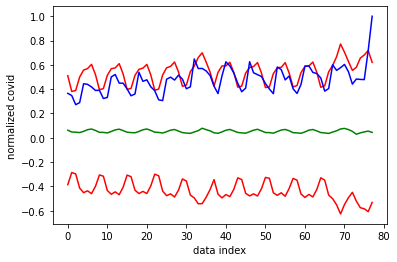

정확도: 0.83
Loss: 0.2182


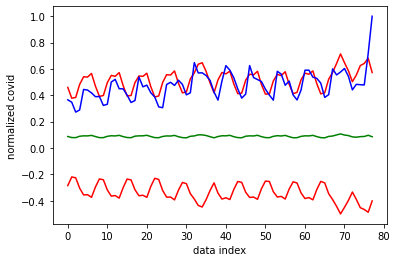

정확도: 0.71
Loss: 0.1183


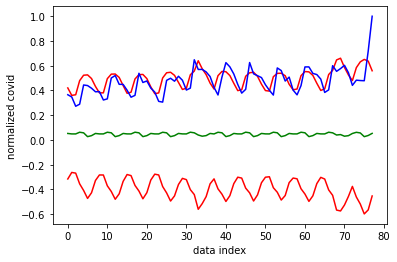

정확도: 0.58
Loss: 0.1937


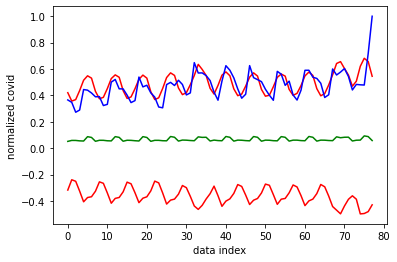

정확도: 0.64
Loss: 0.1787


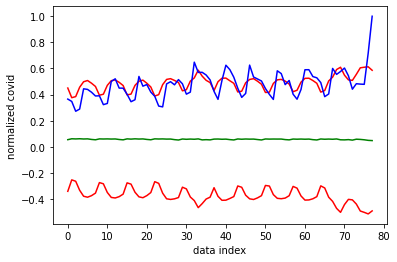

정확도: 0.60
Loss: 0.1826


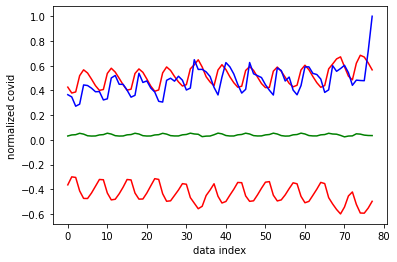

정확도: 0.68
Loss: 0.2250


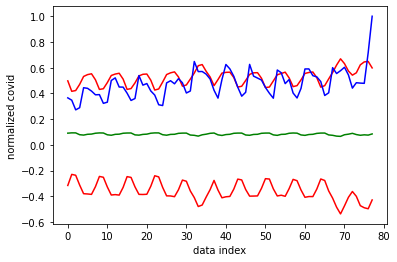

정확도: 0.78
Loss: 0.2456


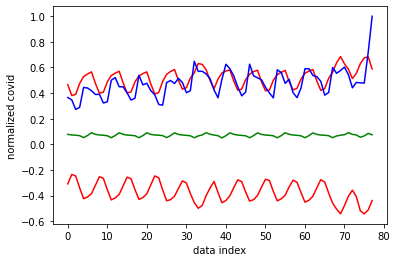

정확도: 0.72
Loss: 0.2132


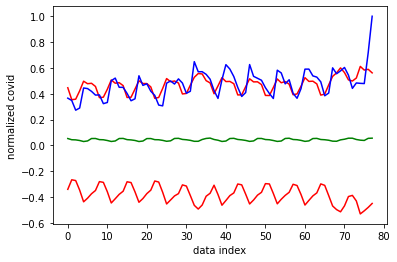

정확도: 0.50
Loss: 0.2281


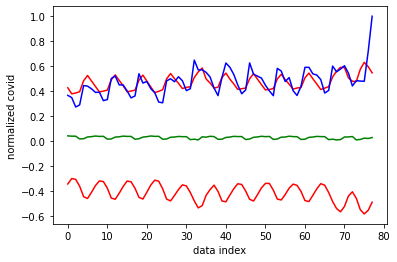

정확도: 0.56
Loss: 0.1958


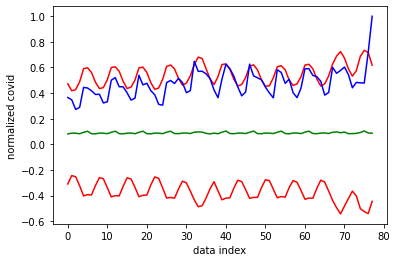

정확도: 0.85
Loss: 0.1982


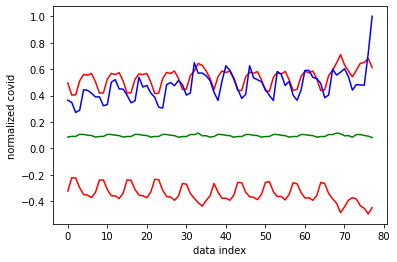

정확도: 0.79
Loss: 0.1993


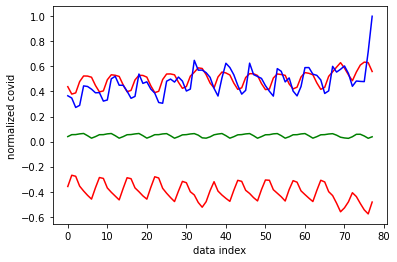

정확도: 0.65
Loss: 0.1869


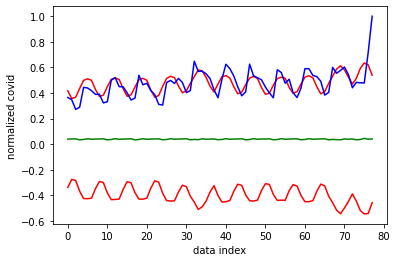

정확도: 0.54
Loss: 0.1777


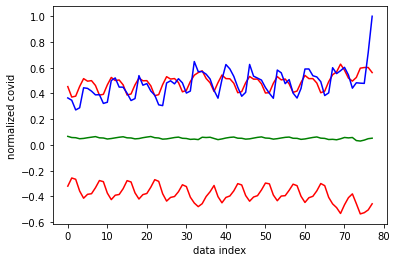

정확도: 0.56
Loss: 0.1468


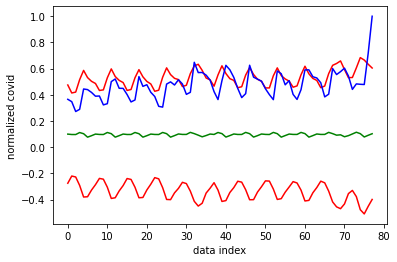

정확도: 0.76
Loss: 0.2337


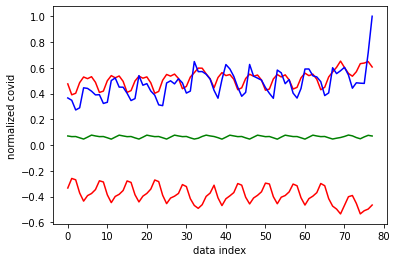

정확도: 0.73
Loss: 0.2172


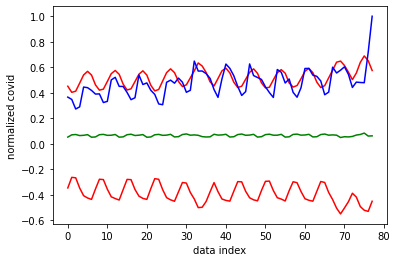

정확도: 0.76
Loss: 0.2331


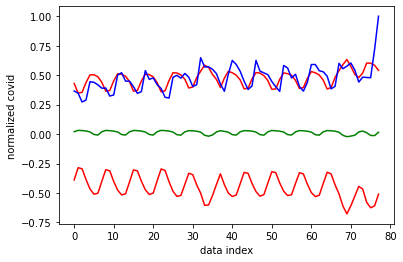

정확도: 0.51
Loss: 0.1963


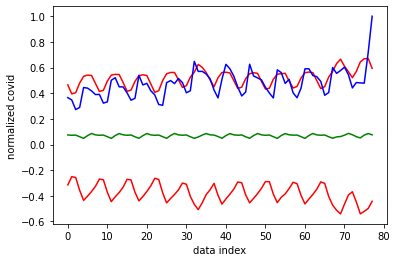

정확도: 0.72
Loss: 0.2333


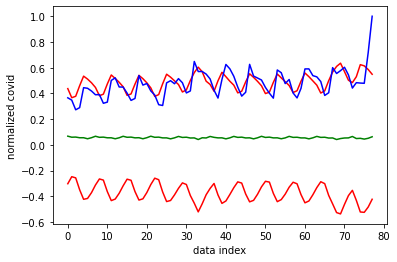

정확도: 0.58
Loss: 0.2001


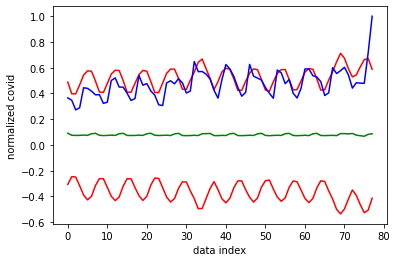

정확도: 0.81
Loss: 0.1845


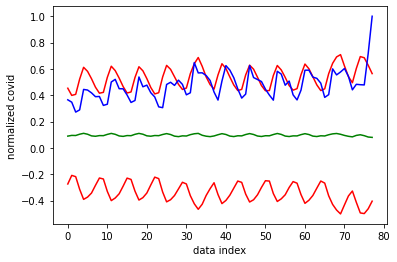

정확도: 0.78
Loss: 0.1742


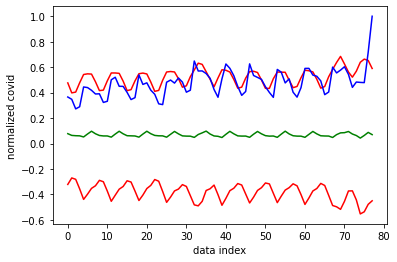

정확도: 0.73
Loss: 0.2256


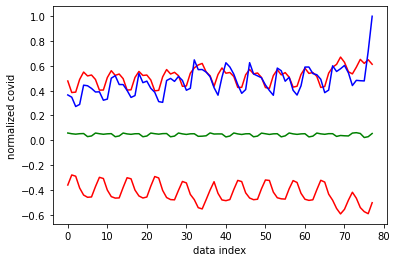

정확도: 0.78
Loss: 0.3385


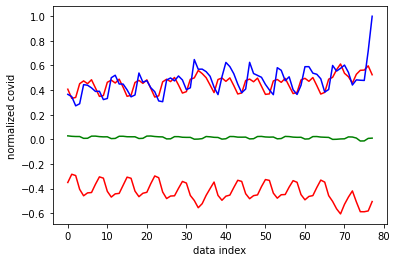

정확도: 0.40
Loss: 0.2234


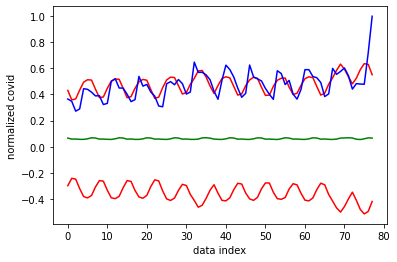

정확도: 0.55
Loss: 0.2137


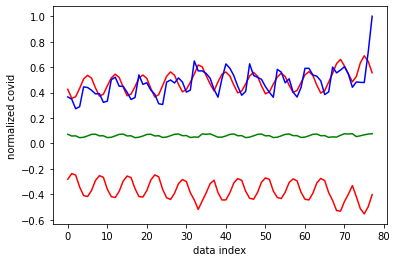

정확도: 0.62
Loss: 0.1930


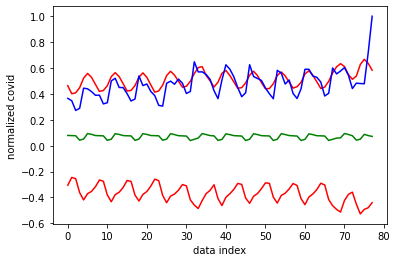

정확도: 0.72
Loss: 0.2241


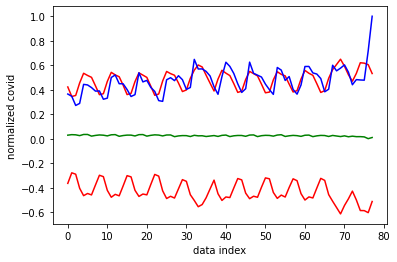

정확도: 0.53
Loss: 0.1780


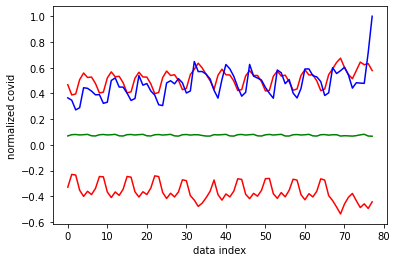

정확도: 0.71
Loss: 0.1792


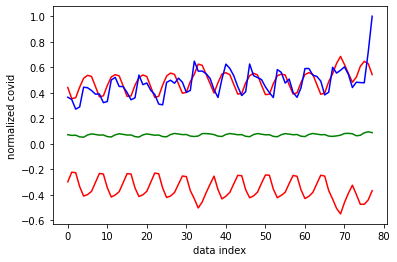

정확도: 0.63
Loss: 0.2205


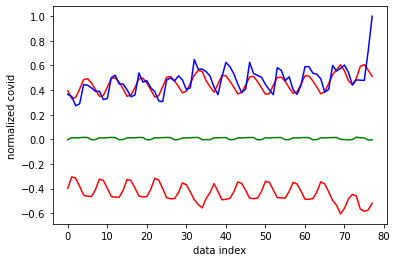

정확도: 0.42
Loss: 0.2036


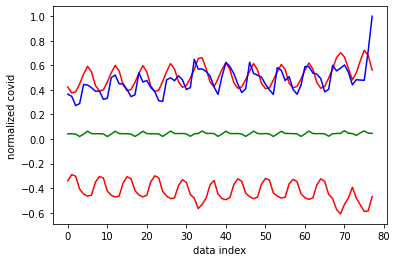

정확도: 0.71
Loss: 0.2170


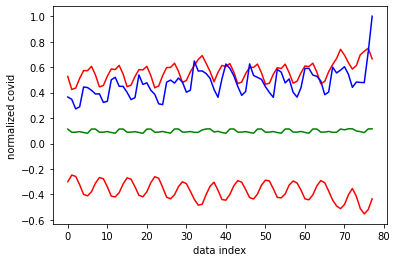

정확도: 0.92
Loss: 0.2024


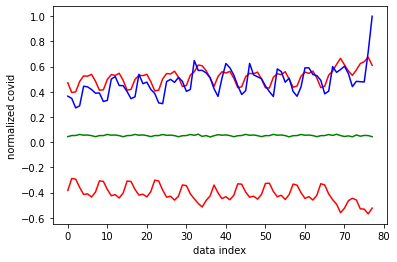

정확도: 0.73
Loss: 0.2421


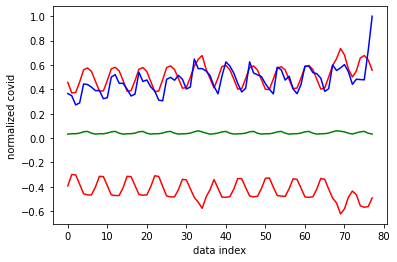

정확도: 0.69
Loss: 0.1913


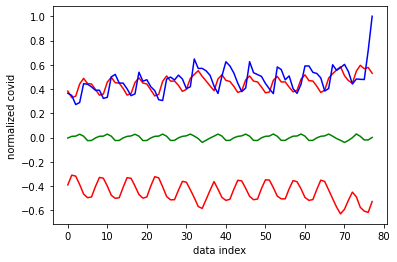

정확도: 0.38
Loss: 0.1730


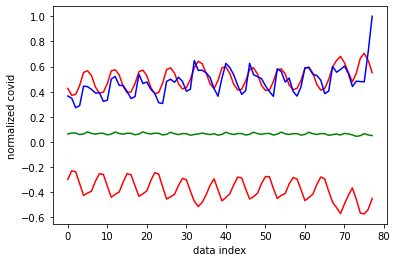

정확도: 0.69
Loss: 0.1509


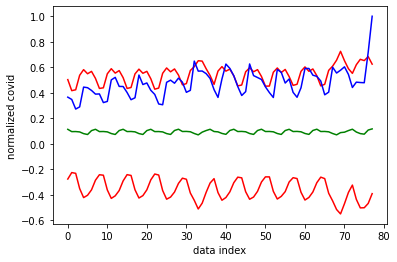

정확도: 0.86
Loss: 0.1906


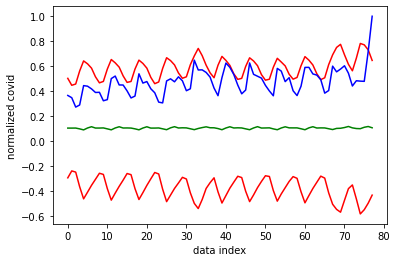

정확도: 0.99
Loss: 0.1933


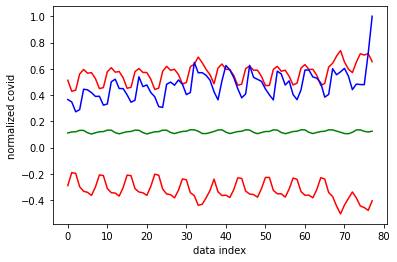

정확도: 0.92
Loss: 0.1699


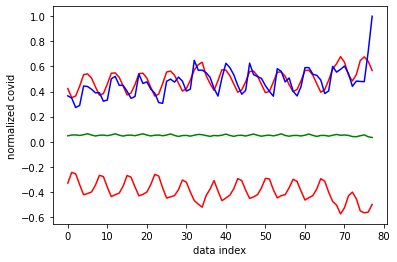

정확도: 0.60
Loss: 0.1781


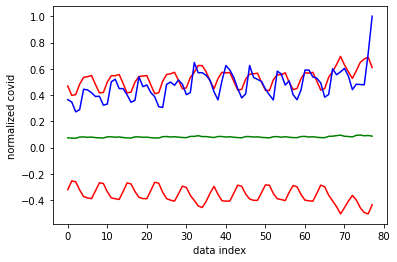

정확도: 0.73
Loss: 0.1949


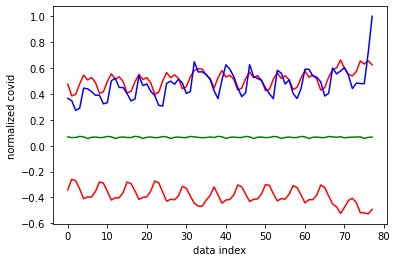

정확도: 0.73
Loss: 0.1892


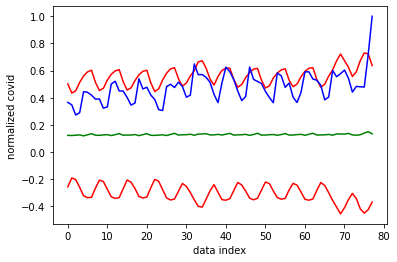

정확도: 0.91
Loss: 0.1994


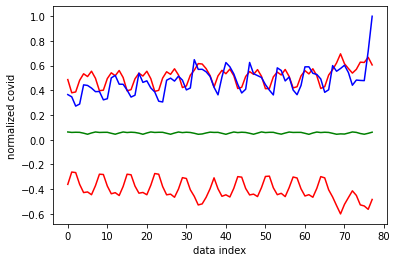

정확도: 0.73
Loss: 0.2085


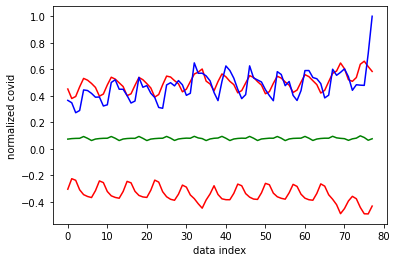

정확도: 0.65
Loss: 0.2503


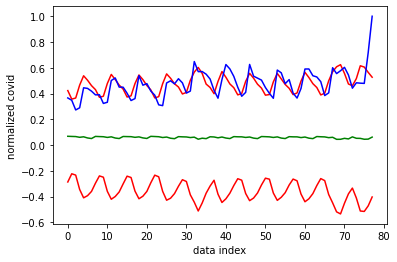

정확도: 0.51
Loss: 0.1679


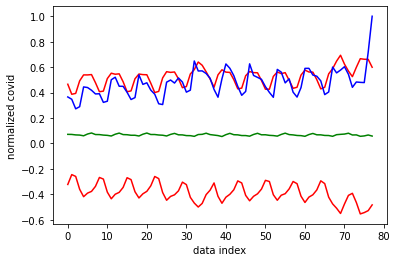

정확도: 0.73
Loss: 0.1773


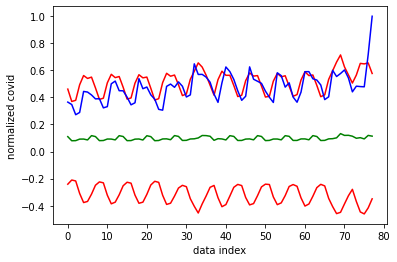

정확도: 0.68
Loss: 0.1906


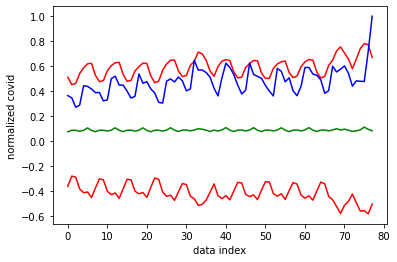

정확도: 0.96
Loss: 0.1578


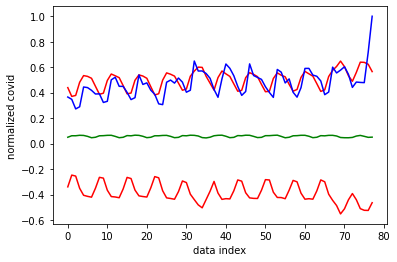

정확도: 0.64
Loss: 0.1844


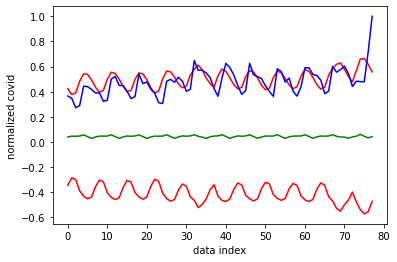

정확도: 0.64
Loss: 0.2381


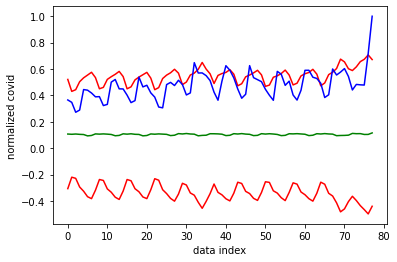

정확도: 0.85
Loss: 0.2239


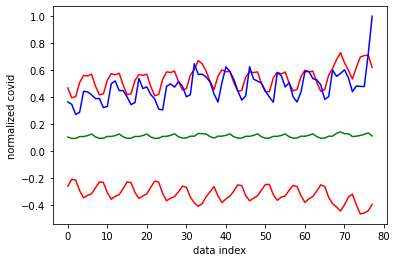

정확도: 0.82
Loss: 0.1771


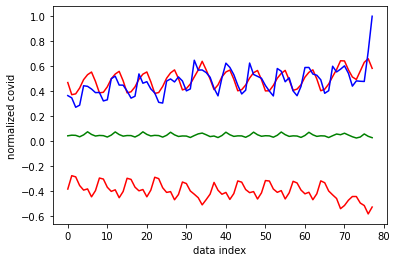

정확도: 0.65
Loss: 0.2778


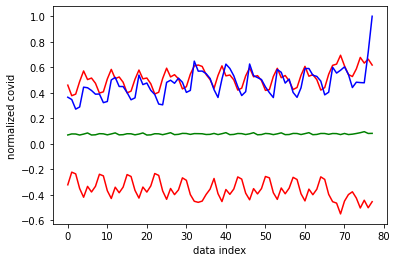

정확도: 0.71
Loss: 0.1675


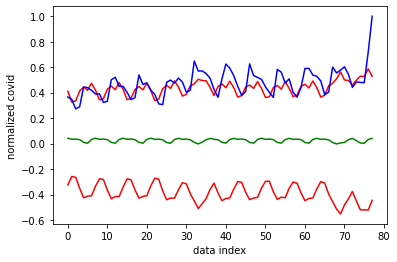

정확도: 0.33
Loss: 0.2487


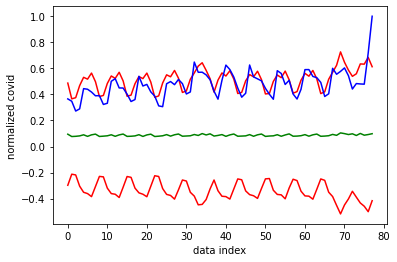

정확도: 0.72
Loss: 0.2002


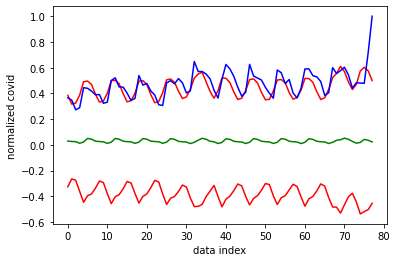

정확도: 0.37
Loss: 0.1168


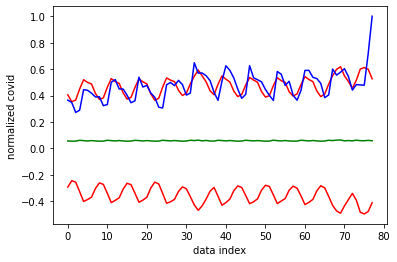

정확도: 0.51
Loss: 0.2159


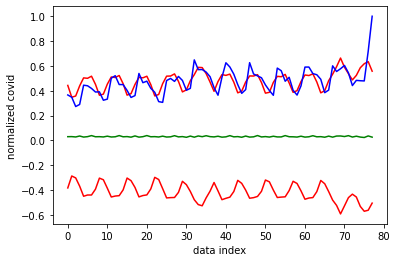

정확도: 0.55
Loss: 0.2423


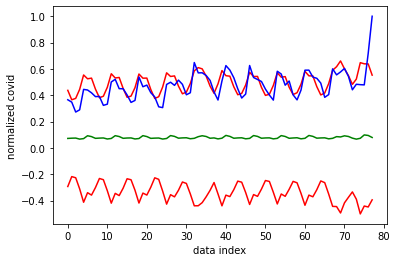

정확도: 0.65
Loss: 0.2081


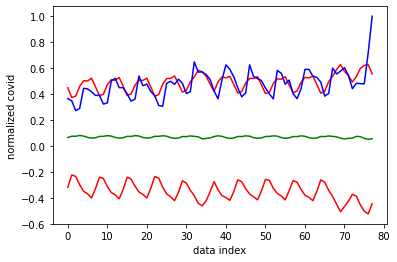

정확도: 0.60
Loss: 0.2409


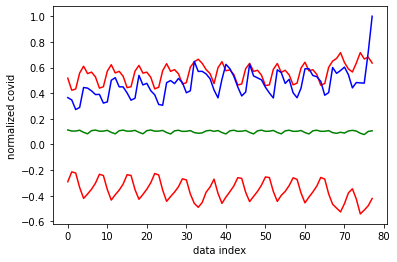

정확도: 0.90
Loss: 0.1923


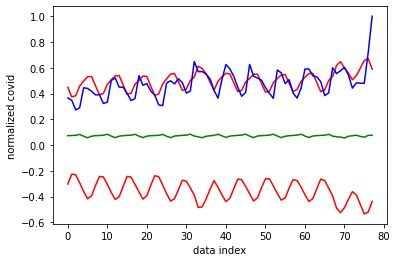

정확도: 0.68
Loss: 0.1929


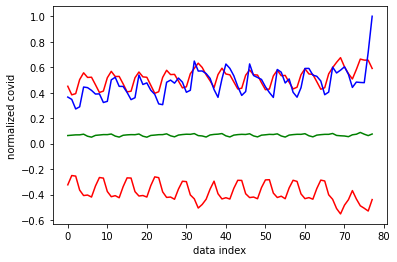

정확도: 0.71
Loss: 0.1649


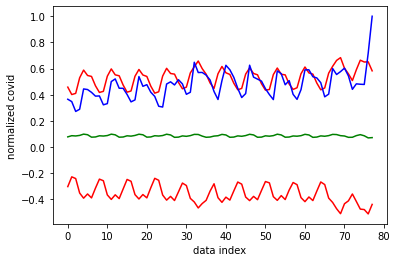

정확도: 0.76
Loss: 0.1872


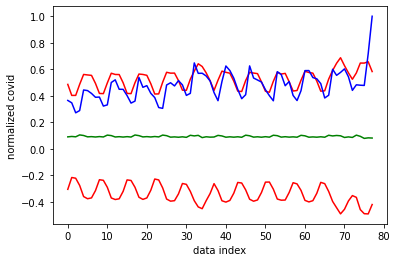

정확도: 0.78
Loss: 0.2339


In [20]:
import matplotlib.pyplot as plt

def evaluate_regression(regressor,
                        x,
                        y,
                        samples,
                        std_multiplier):
    preds = [regressor(x) for i in range(samples)]#100개의 베이시안 모델 리스트 생성
    preds = torch.stack(preds)#탠서 쌓기(실제 학습결과 값)
    means = preds.mean(axis=0)#탠서 평균
    stds = preds.std(axis=0)# 탠서 표준편차
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    u=pd.DataFrame(ci_upper)
    m=pd.DataFrame(means)
    l=pd.DataFrame(ci_lower)
    plt.plot(u,'r',m,'g',l,'r',pd.DataFrame(y),'b')
    plt.xlabel('data index')
    plt.ylabel('normalized covid')
    plt.show()
    plt.close()
    ic_acc = (ci_upper >= y).float().mean()*(ci_lower <= y).float().mean()
    return ic_acc

iteration = 0
for epoch in range(1000):
    for i, (datapoints, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=1/train_x.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%19==0:
            ic_acc=evaluate_regression(regressor,
                    test_x.to(device),
                    test_y.to(device),
                    samples=200,std_multiplier=2.0)
            print("정확도: {:.2f}".format(ic_acc))
            print("Loss: {:.4f}".format(loss))
